In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=r"Your `PyDataset` class should call `super().__init__\(\*\*kwargs\)`")

In [2]:
df = pd.read_csv("D:\code_study\ML_CODE\dataSets\Butterfly Image Classification\Training_set.csv")
df.head(10)

filename                     label
0   Image_1.jpg          SOUTHERN DOGFACE
1   Image_2.jpg                    ADONIS
2   Image_3.jpg            BROWN SIPROETA
3   Image_4.jpg                   MONARCH
4   Image_5.jpg  GREEN CELLED CATTLEHEART
5   Image_6.jpg           CAIRNS BIRDWING
6   Image_7.jpg  GREEN CELLED CATTLEHEART
7   Image_8.jpg      EASTERN DAPPLE WHITE
8   Image_9.jpg            BROWN SIPROETA
9  Image_10.jpg               RED POSTMAN

In [3]:
len(df)

6499

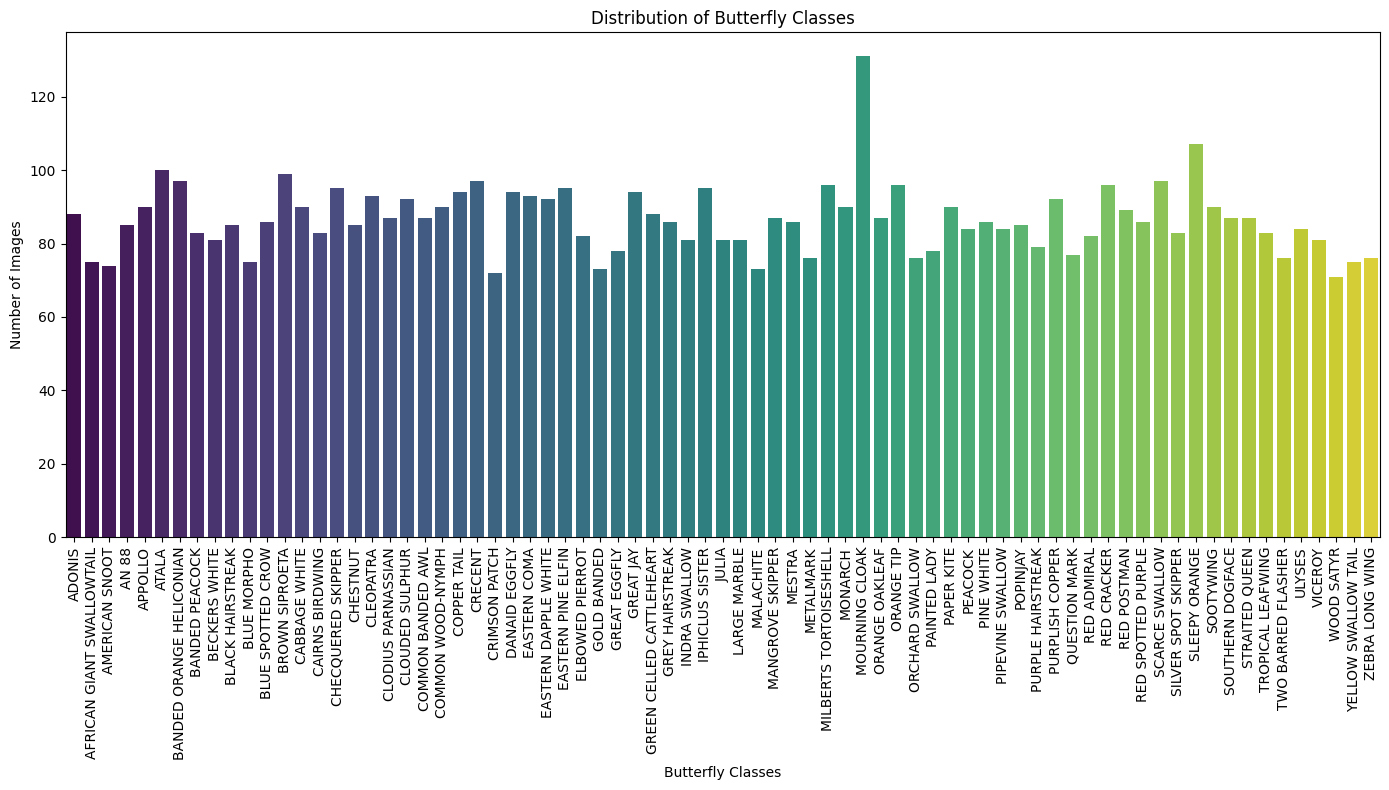

In [4]:
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Butterfly Classes')
plt.xlabel('Butterfly Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

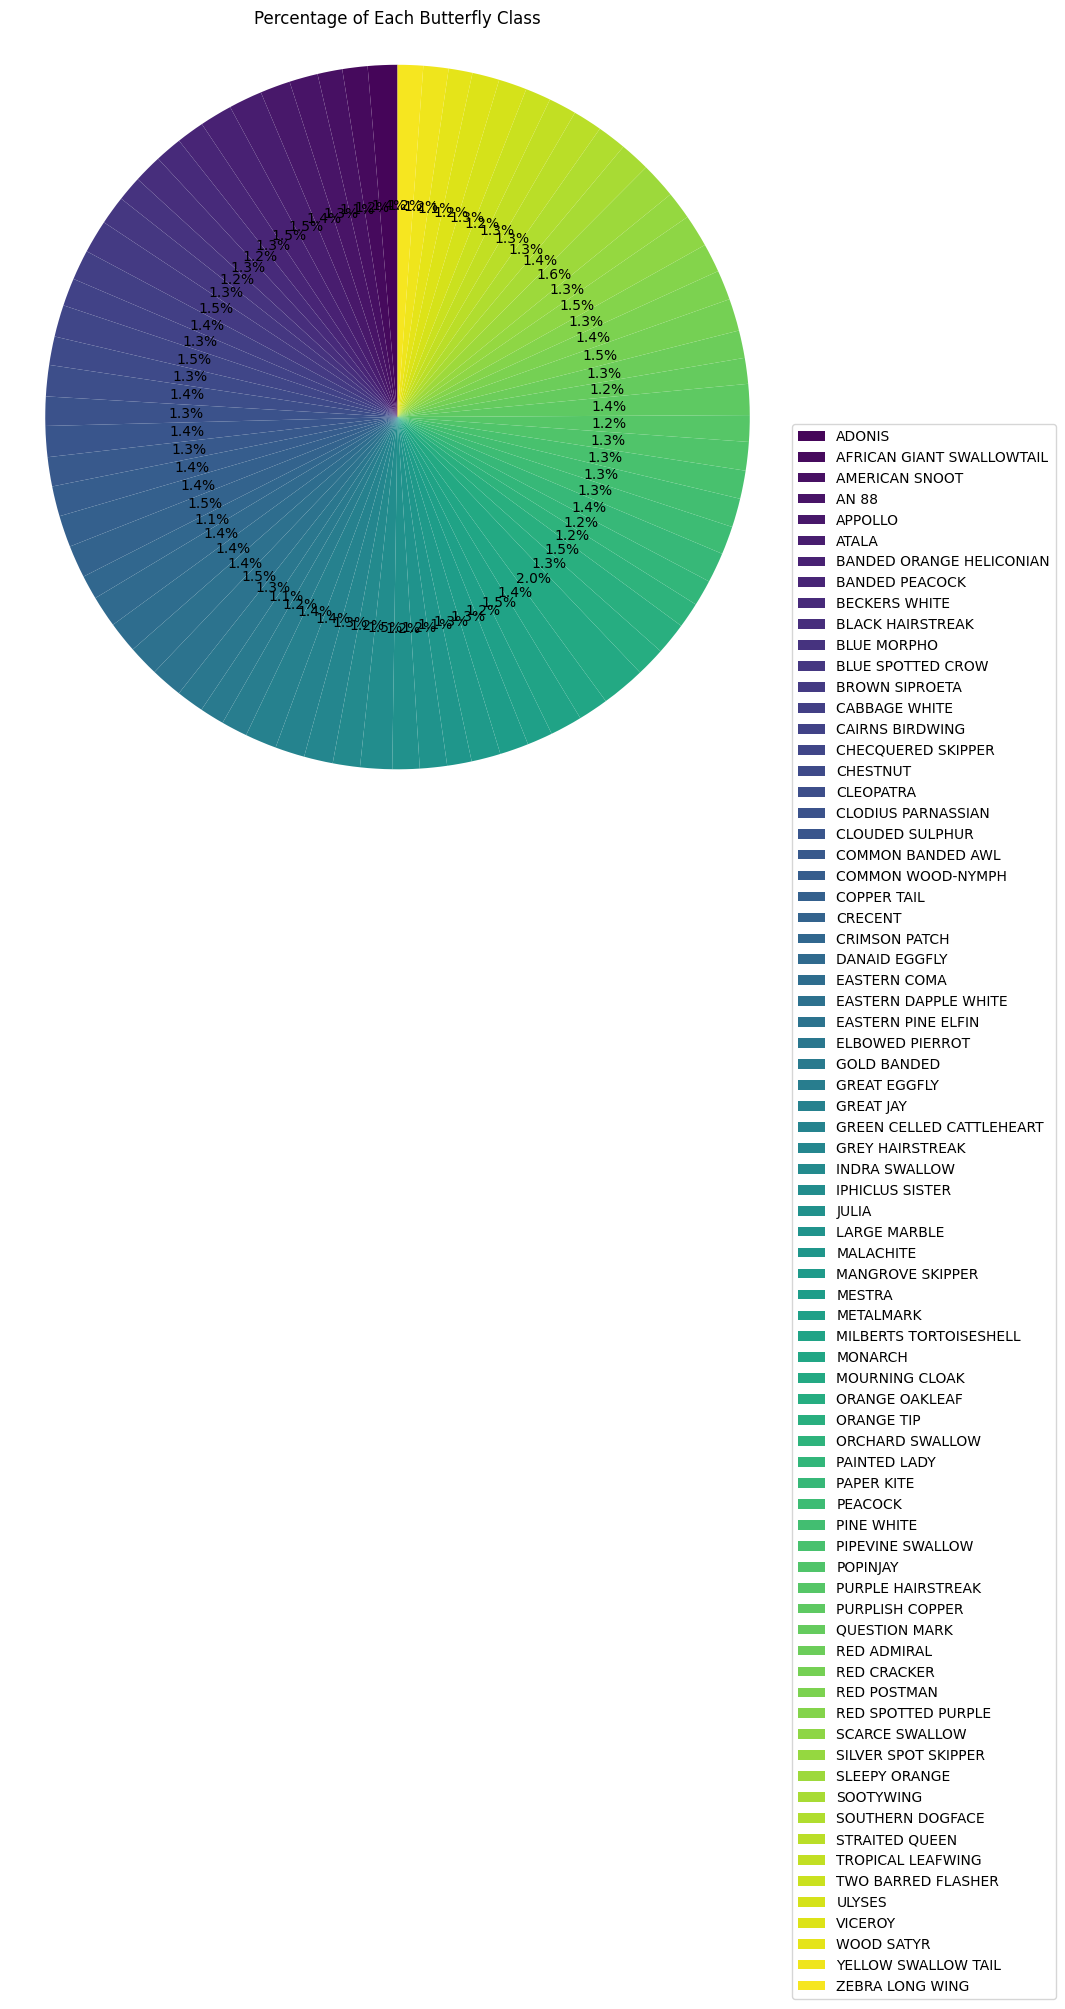

In [5]:
colors = sns.color_palette("viridis", len(class_counts))
class_counts = df['label'].value_counts().sort_index()


plt.figure(figsize=(10, 10))
plt.pie(class_counts.values, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Each Butterfly Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(class_counts.index, loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:
import pathlib
image_dir = r"D:\code_study\ML_CODE\dataSets\Butterfly Image Classification\train"
image_dir = pathlib.Path(image_dir)


sample_images = df.sample(9, random_state=42)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['filename'])
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = r"D:\code_study\ML_CODE\dataSets\Butterfly Image Classification\train"
image_dir = pathlib.Path(image_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [11]:
model_CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [13]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    workers=5
)

Epoch 1/40
162/162 [==============================] - 32s 201ms/step - loss: 3.4791 - accuracy: 0.1302 - val_loss: 2.8791 - val_accuracy: 0.2578
Epoch 2/40
162/162 [==============================] - 5s 28ms/step - loss: 2.7053 - accuracy: 0.2711 - val_loss: 2.4763 - val_accuracy: 0.3609
Epoch 3/40
162/162 [==============================] - 5s 28ms/step - loss: 2.2090 - accuracy: 0.3869 - val_loss: 1.8407 - val_accuracy: 0.4648
Epoch 4/40
162/162 [==============================] - 5s 28ms/step - loss: 1.9191 - accuracy: 0.4564 - val_loss: 2.0634 - val_accuracy: 0.4656
Epoch 5/40
162/162 [==============================] - 5s 28ms/step - loss: 1.7116 - accuracy: 0.5057 - val_loss: 1.5377 - val_accuracy: 0.5711
Epoch 6/40
162/162 [==============================] - 5s 29ms/step - loss: 1.5340 - accuracy: 0.5587 - val_loss: 1.5969 - val_accuracy: 0.5617
Epoch 7/40
162/162 [==============================] - 5s 29ms/step - loss: 1.4434 - accuracy: 0.5823 - val_loss: 1.3876 - val_accuracy: 0.59

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

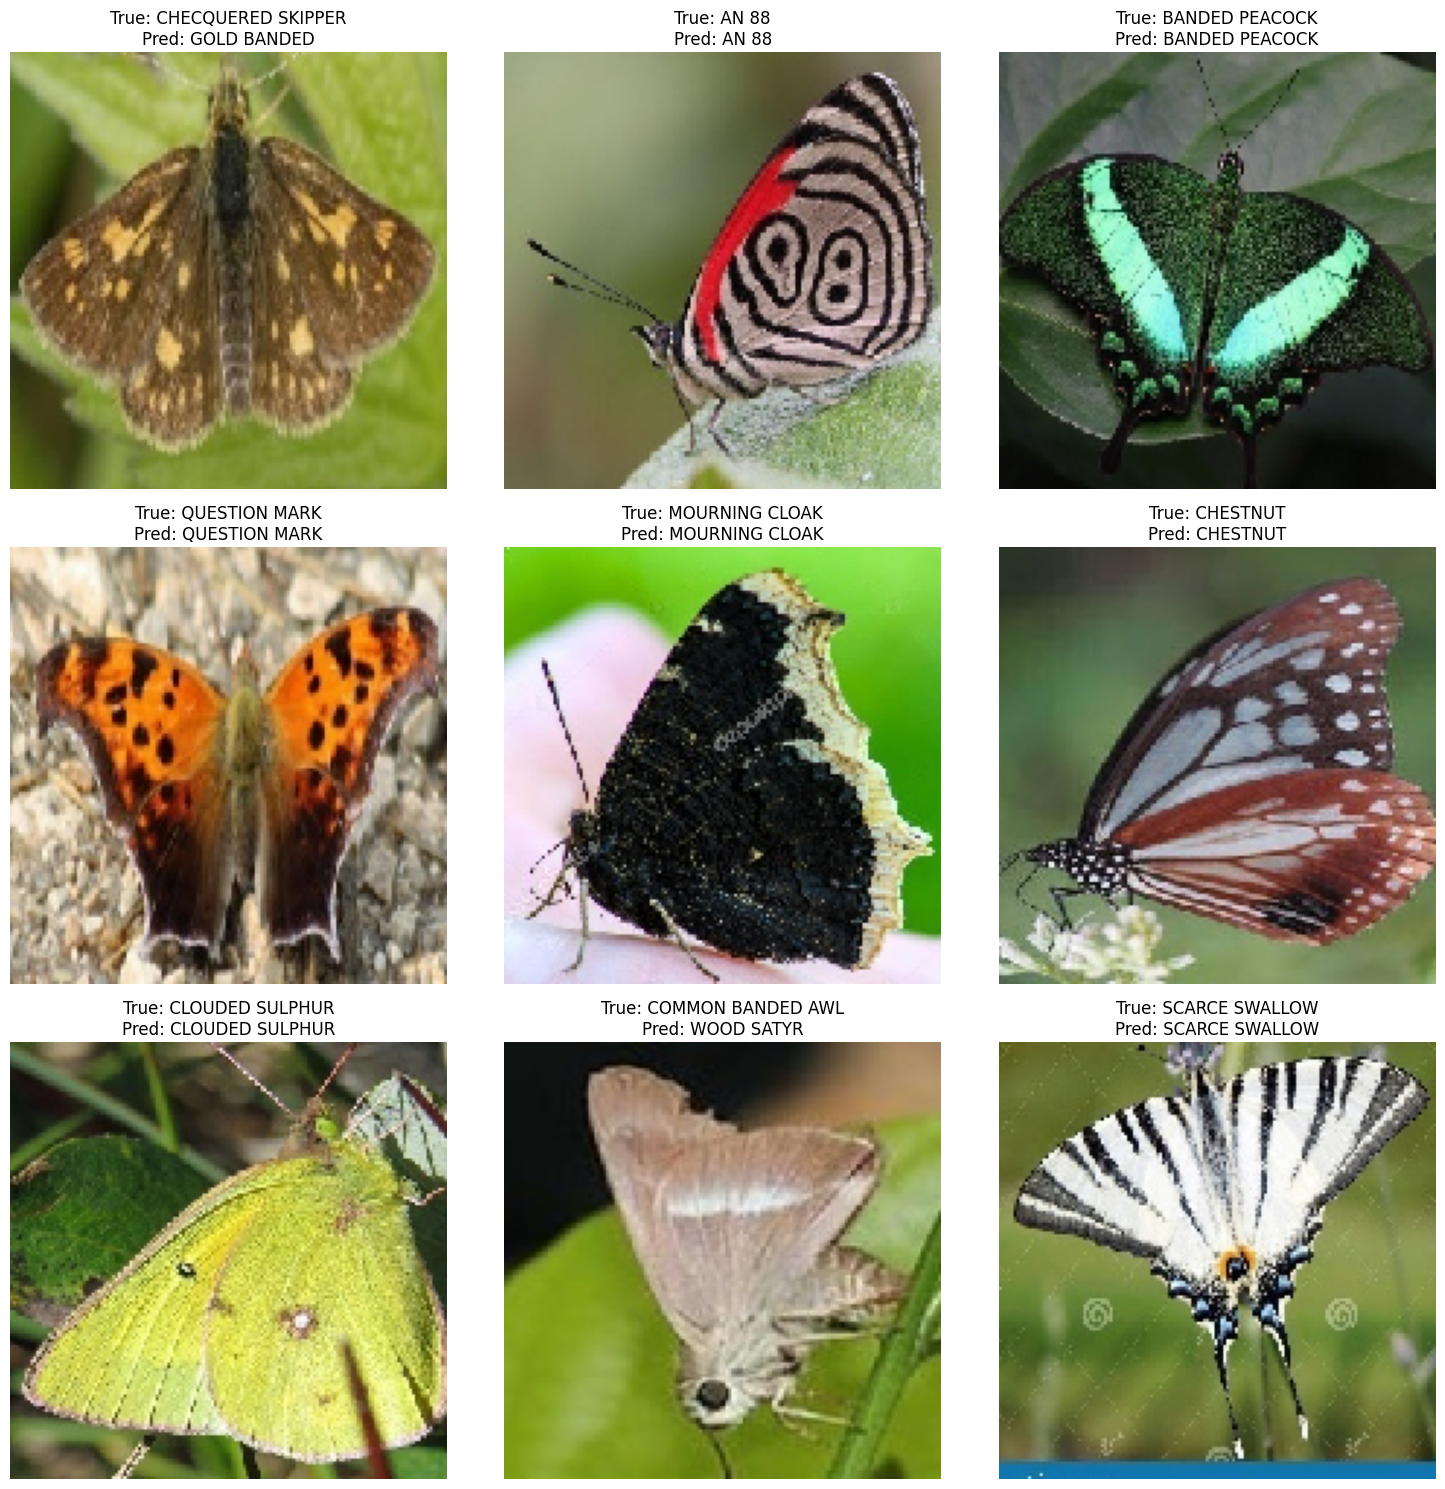

In [15]:
val_images, val_labels = next(val_generator)

pred_labels = model_CNN.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)